# U2T3 - Classic Algorithms

## Overview

In this third and final assignment for Unit 2, we'll explore the differences (if any) in results obtained by the native Dijsktra implementation in networkX's shortest path algorithm and the version using Min Heap as an auxiliary data structure. In the second part we'll reuse the paths to find the Minimum Spanning Tree (MST) using Kruskal's Algorithm to connect all points of interest with minimal cost. And finally we'll wrap things up with an overall analysis.

## Browse
* [Data and Points of Interest](#data-and-points-of-interest)
* [Shortest Path Algorithm Comparison](#shortest-path-algorithm-comparison)
* [Minimum Spanning Tree](#minimum-spanning-tree)
* [Analysis and Conclusion](#analysis-and-conclusion)

These next 3 code cells set the stage for all the work we'll do thereafter. The `MinHeap` class implementation and the `to_undirected_multigraph` were handed out by the professor.

In [13]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

In [14]:
class MinHeap:
    """
    MinHeap class: Implements a MinHeap data structure to efficiently manage vertices and their distances
    for algorithms like Dijkstra. This implementation keeps track of the position of each vertex using
    a vertex map for constant-time lookups and updates.
    """
    def __init__(self, array):
        """
        Initializes the MinHeap with an input array of (vertex, distance) pairs.

        Args:
            array (list): List of tuples where each tuple is (vertex, distance).
                          The distance is typically initialized to infinity except for the starting vertex.

        Attributes:
            vertexMap (dict): Maps each vertex to its position in the heap for quick access.
            heap (list): List representing the binary heap as an array.
        """
        # Create a vertex map: Maps vertices to their indices in the heap.
        self.vertexMap = {idx: idx for idx in range(len(array))}

        # Build the heap from the input array to satisfy the heap property.
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        """
        Checks if the heap is empty.

        Returns:
            bool: True if the heap is empty, False otherwise.
        """
        return len(self.heap) == 0

    def buildHeap(self, array):
        """
        Builds the heap from an input array in O(n) time.

        Args:
            array (list): List of (vertex, distance) pairs.

        Returns:
            list: The input array transformed into a valid MinHeap.
        """
        # Start from the first parent node and sift down each node.
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        """
        Restores the heap property by "sifting down" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift down.
            endIdx (int): Last index in the heap.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        childOneIdx = currentIdx * 2 + 1  # Index of the first child
        while childOneIdx <= endIdx:
            # Determine the index of the second child
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1

            # Choose the smaller child to maintain the min-heap property
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx

            # Swap if the child is smaller than the current node
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap  # Move to the swapped position
                childOneIdx = currentIdx * 2 + 1  # Update the first child index
            else:
                return

    def siftUp(self, currentIdx, heap):
        """
        Restores the heap property by "sifting up" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift up.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        parentIdx = (currentIdx - 1) // 2  # Calculate parent index
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)  # Swap with parent
            currentIdx = parentIdx  # Move to the parent's position
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        """
        Removes and returns the smallest element (root) in the heap.

        Returns:
            tuple: The (vertex, distance) pair with the smallest distance.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        if self.isEmpty():
            return None

        # Swap the root with the last element and remove it
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)  # Remove the vertex from the map

        # Restore the heap property
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        """
        Swaps two nodes in the heap and updates their positions in the vertexMap.

        Args:
            i (int): Index of the first node.
            j (int): Index of the second node.
            heap (list): The heap array.
        """
        self.vertexMap[heap[i][0]] = j  # Update vertexMap for heap[i]
        self.vertexMap[heap[j][0]] = i  # Update vertexMap for heap[j]
        heap[i], heap[j] = heap[j], heap[i]  # Swap the nodes in the heap

    def update(self, vertex, value):
        """
        Updates the distance of a given vertex and restores the heap property.

        Args:
            vertex (int): The vertex whose distance is to be updated.
            value (int): The new distance value.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        # Update the heap with the new (vertex, value) pair
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        # Restore the heap property by sifting up the updated node
        self.siftUp(self.vertexMap[vertex], self.heap)

# O((v + e) * log(v)) time | O(v) space — where v is the number
# of vertices and e is the number of edges in the input graph
def dijkstrasAlgorithm(start, edges):
    """
    Implements Dijkstra's algorithm to find the shortest paths from a starting vertex to all other vertices
    in a weighted graph. The graph is represented using an adjacency list.

    Args:
        start (int): The starting vertex index.
        edges (list of list): An adjacency list where each index represents a vertex, and each entry
                              is a list of [destination, weight] pairs.

    Returns:
        list: A list of minimum distances from the starting vertex to each vertex in the graph.
              If a vertex is unreachable, its distance is represented as -1.
    """
    # Step 1: Initialize the number of vertices in the graph
    numberOfVertices = len(edges)

    # Step 2: Initialize the minimum distances with infinity
    # Set the starting vertex's distance to 0
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Step 3: Initialize the MinHeap to track the vertices and their current shortest distances
    minDistancesHeap = MinHeap([(idx, float("inf")) for idx in range(numberOfVertices)])
    minDistancesHeap.update(start, 0)  # Update the starting vertex's distance to 0

    # Step 4: Process vertices until the heap is empty
    while not minDistancesHeap.isEmpty():
        # Extract the vertex with the smallest known distance
        vertex, currentMinDistance = minDistancesHeap.remove()

        # If the current distance is infinity, no further reachable vertices exist
        if currentMinDistance == float("inf"):
            break

        # Step 5: Relaxation - Update distances for all neighboring vertices
        for edge in edges[vertex]:
            destination, distanceToDestination = edge  # Extract neighbor and weight

            # Calculate the new potential path distance
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # If the new path is shorter, update the distance and the heap
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance
                minDistancesHeap.update(destination, newPathDistance)

    # Step 6: Convert unreachable vertices' distances from infinity to -1
    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

def dijkstrasAlgorithmWithPaths(start, edges):
    """
    Implements Dijkstra's algorithm to compute the shortest paths from a starting vertex to all other vertices
    in a weighted graph. It also tracks the predecessors of each vertex for path reconstruction.

    Args:
        start (int): The index of the starting vertex.
        edges (list of list): Adjacency list representation of the graph, where each index represents a vertex,
                              and each entry is a list of [destination, weight] pairs.

    Returns:
        tuple: A tuple containing:
            - minDistances (list): A list of the shortest distances from the starting vertex to each vertex.
                                   Vertices that are unreachable will have a distance of `float("inf")`.
            - previousNodes (list): A list where each index points to the predecessor of the vertex
                                    in the shortest path. If no path exists, the predecessor is `None`.

    Algorithm Steps:
        1. Initialize distances with `infinity` and set the starting vertex distance to 0.
        2. Use a MinHeap to manage and efficiently retrieve the vertex with the smallest known distance.
        3. For each vertex, relax its edges to update distances to neighboring vertices.
        4. Track the predecessor of each vertex to allow path reconstruction later.
        5. Return the minimum distances and the list of predecessors.
    """
    numberOfVertices = len(edges)  # Total number of vertices in the graph

    # Step 1: Initialize minimum distances and predecessors
    minDistances = [float("inf")] * numberOfVertices  # All distances set to infinity initially
    minDistances[start] = 0  # Distance to the start node is 0

    previousNodes = [None] * numberOfVertices  # Array to store the predecessor of each vertex

    # Step 2: Initialize the MinHeap
    heap = MinHeap([(i, float("inf")) for i in range(numberOfVertices)])
    heap.update(start, 0)  # Update the distance of the starting vertex to 0

    # Step 3: Process vertices until the heap is empty
    while not heap.isEmpty():
        # Extract the vertex with the smallest known distance
        vertex, currentMinDistance = heap.remove()

        # Ignore outdated distances (e.g., if a shorter distance was already found)
        if currentMinDistance > minDistances[vertex]:
            continue

        # Step 4: Relaxation - Update distances to neighboring vertices
        for edge in edges[vertex]:
            destination, weight = edge  # Extract destination vertex and edge weight

            # Calculate the new potential distance to the destination vertex
            newPathDistance = currentMinDistance + weight

            # Update if the new path is shorter
            if newPathDistance <= minDistances[destination]:
                minDistances[destination] = newPathDistance
                previousNodes[destination] = vertex  # Track the predecessor for path reconstruction
                heap.update(destination, newPathDistance)  # Update the heap with the new distance

    return minDistances, previousNodes

def reconstructPath(previousNodes, start, end):
    """
    Reconstructs the shortest path from the start node to the end node using the predecessor list.

    Args:
        previousNodes (list): A list where each index corresponds to a node, and the value at that index
                              is the predecessor node in the shortest path. `None` indicates no predecessor.
        start (int): The starting node index.
        end (int): The destination node index.

    Returns:
        list: A list of nodes representing the shortest path from the start node to the end node.
              If no path exists, returns an empty list.

    Algorithm:
        1. Start from the destination node (`end`) and trace back to the start node (`start`) using
           the `previousNodes` list.
        2. Append each node encountered to the `path` list.
        3. Reverse the `path` list to produce the correct order from start to end.
        4. If no valid path exists (e.g., disconnected graph), return an empty list.

    Example:
        previousNodes = [None, 0, 1, 2]  # Predecessor list
        start = 0
        end = 3
        reconstructPath(previousNodes, start, end) -> [0, 1, 2, 3]
    """
    path = []  # Initialize an empty list to store the path
    currentNode = end  # Start tracing from the destination node

    # Step 1: Trace back from the destination node to the start node
    while currentNode is not None and currentNode != start:
        path.append(currentNode)  # Add the current node to the path
        currentNode = previousNodes[currentNode]  # Move to the predecessor node

    # Step 2: Add the start node if a valid path was found
    if currentNode == start:
        path.append(start)  # Add the start node to the path
        path.reverse()  # Reverse the path to get the correct order from start to end
        return path

    # Step 3: If no path exists, return an empty list
    return []

In [15]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

## Data and Points of Interest

First we get the graph for the drive network of Natal, our place of interest in this assignment, then we convert it to an undirected multigraph (required by the MST algorithm).

In [16]:
# Get the city graph
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Convert the MultiDiGraph to a MultiGraph
G_undirected = to_undirected_multigraph(G)

In order to perform our work, we define 20 points of interest (POIs) inside the city. Then we split them into pairs of origin-destination.

> Notes:
> - The coordinates for each POI came from [Google Maps](http://maps.google.com).
> - The `close_nodes` list is optional and serves the only purpose of making the result's visualization more neat.
> - The pair o/d in `trips` were chosen loosely following the thematic of the POIs (e.g. Museu Câmara Cascudo and Complexo Cultural da Rampa both are related to history and culture) 

In [17]:
points_of_interest = {
    "Bosque dos Namorados": (-5.810000795027978, -35.19480001458137),
    "Midway Mall": (-5.810663147657472, -35.20635241363344),
    "Arena das Dunas": (-5.8255208099087685, -35.21211501630162),
    "Frasqueirão": (-5.887867824301646, -35.17943357038032),
    "Morro do Careca": (-5.883512001633996, -35.16455168701718),
    "Centro de Convenções": (-5.861949383263805, -35.182301234561635),
    "Natal Shopping": (-5.841964626772185, -35.21165060057929),
    "Forte dos Reis Magos": (-5.755577564085997, -35.19532423200888),
    "Ginásio Nélio Dias": (-5.732258940317272, -35.254032908482074),
    "16º Batalhão de Infantaria Motorizado": (-5.80297026119303, -35.19799061795743),
    "7º Batalhão de Engenharia de Combate": (-5.829002734830578, -35.20149321407703),
    "Cidade da Criança": (-5.796558806172644, -35.20265113873726),
    "Parque da Cidade": (-5.850401831184538, -35.2265962580863),
    "Praça Pedro Velho": (-5.784168853005139, -35.20084503035161),
    "Marinha do Brasil": (-5.7894486111299015, -35.2217889263516),
    "Comando do 3º Distrito Naval": (-5.766706342343219, -35.20260534284491),
    "Teatro Alberto Maranhão": (-5.779269622644239, -35.20477172089475),
    "Complexo Cultural da Rampa": (-5.767529123764402, -35.20397248895139),
    "Museu Câmara Cascudo": (-5.803226231123536, -35.20189425871672),
    "Partage Norte Shopping": (-5.757452335421804, -35.246914706673216),
}
close_nodes = ["Bosque dos Namorados", "Praça Pedro Velho", "Complexo Cultural da Rampa", "Museu Câmara Cascudo"]

In [18]:
trips = [
    ("Museu Câmara Cascudo", "Complexo Cultural da Rampa"),
    ("Frasqueirão", "Arena das Dunas"),
    ("16º Batalhão de Infantaria Motorizado", "7º Batalhão de Engenharia de Combate"),
    ("Parque da Cidade", "Cidade da Criança"),
    ("Praça Pedro Velho", "Bosque dos Namorados"),
    ("Marinha do Brasil", "Comando do 3º Distrito Naval"),
    ("Midway Mall", "Teatro Alberto Maranhão"),
    ("Centro de Convenções", "Natal Shopping"),
    ("Ginásio Nélio Dias", "Partage Norte Shopping"),
    ("Morro do Careca", "Forte dos Reis Magos"),
]

The code cell below has the job of translating the coordinates of the POIs into nodes in the graph to enable us to work on them later. Also we update the dictionary to correspond to the more useful node.

In [19]:
# Take the POI in the dictionary and get the closest node in the graph
latitudes, longitudes = zip(*points_of_interest.values())
pois_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
# Update the dictionary with the closest nodes
points_of_interest = dict(zip(points_of_interest.keys(), pois_nodes))

## Shortest Path Algorithm Comparison

Before we can compare the algorithms, some adjustments have to be made. The function `dijkstrasAlgorithmWithPaths` requires the edges to be an adjacency list in a specific configuration and the nodes to be integers. The following code cells made sure to account for this requirements.

> Notes:
> - Even though the osmid of each node in the graph is an integer, the index and reverse index mappings short the length of the list of edges since its index correspond to the node id value (in the original case, osmid tends to be big)
> - The for loop creates the edge list with the appropriate information gathered from the `adjacency` method


In [20]:
index_mapping = {node: i for i, node in enumerate(G_undirected.nodes())}
reverse_index_mapping = {i: node for i, node in enumerate(G_undirected.nodes())}

In [21]:
edges = [[] for _ in range(len(G_undirected.nodes()))]
for n, nbrdict in G_undirected.adjacency():
    for node, keydict in nbrdict.items():
        edges[index_mapping[n]].append([index_mapping[node], keydict[0]['length']])

This following piece of code is responsible for calculating and storing the pair of routes for each trip.

In [22]:
routes = []
trip_total_distance = 0
for trip in trips:
    origin, destination = trip
    origin_node = points_of_interest[origin]
    destination_node = points_of_interest[destination]
    routes.append(nx.shortest_path(G_undirected, origin_node, destination_node, weight='length'))
    
    # Used for comparison later
    trip_total_distance += nx.shortest_path_length(G_undirected, origin_node, destination_node, weight='length')

    _, previousNodes = dijkstrasAlgorithmWithPaths(index_mapping[origin_node], edges)
    alternative_route = reconstructPath(previousNodes, index_mapping[origin_node], index_mapping[destination_node])
    alternative_route = [reverse_index_mapping[node] for node in alternative_route]
    routes.append(alternative_route)
    

c:\Users\Filipe\AppData\Local\Programs\Python\Python311\Lib\site-packages\osmnx\plot.py:334: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


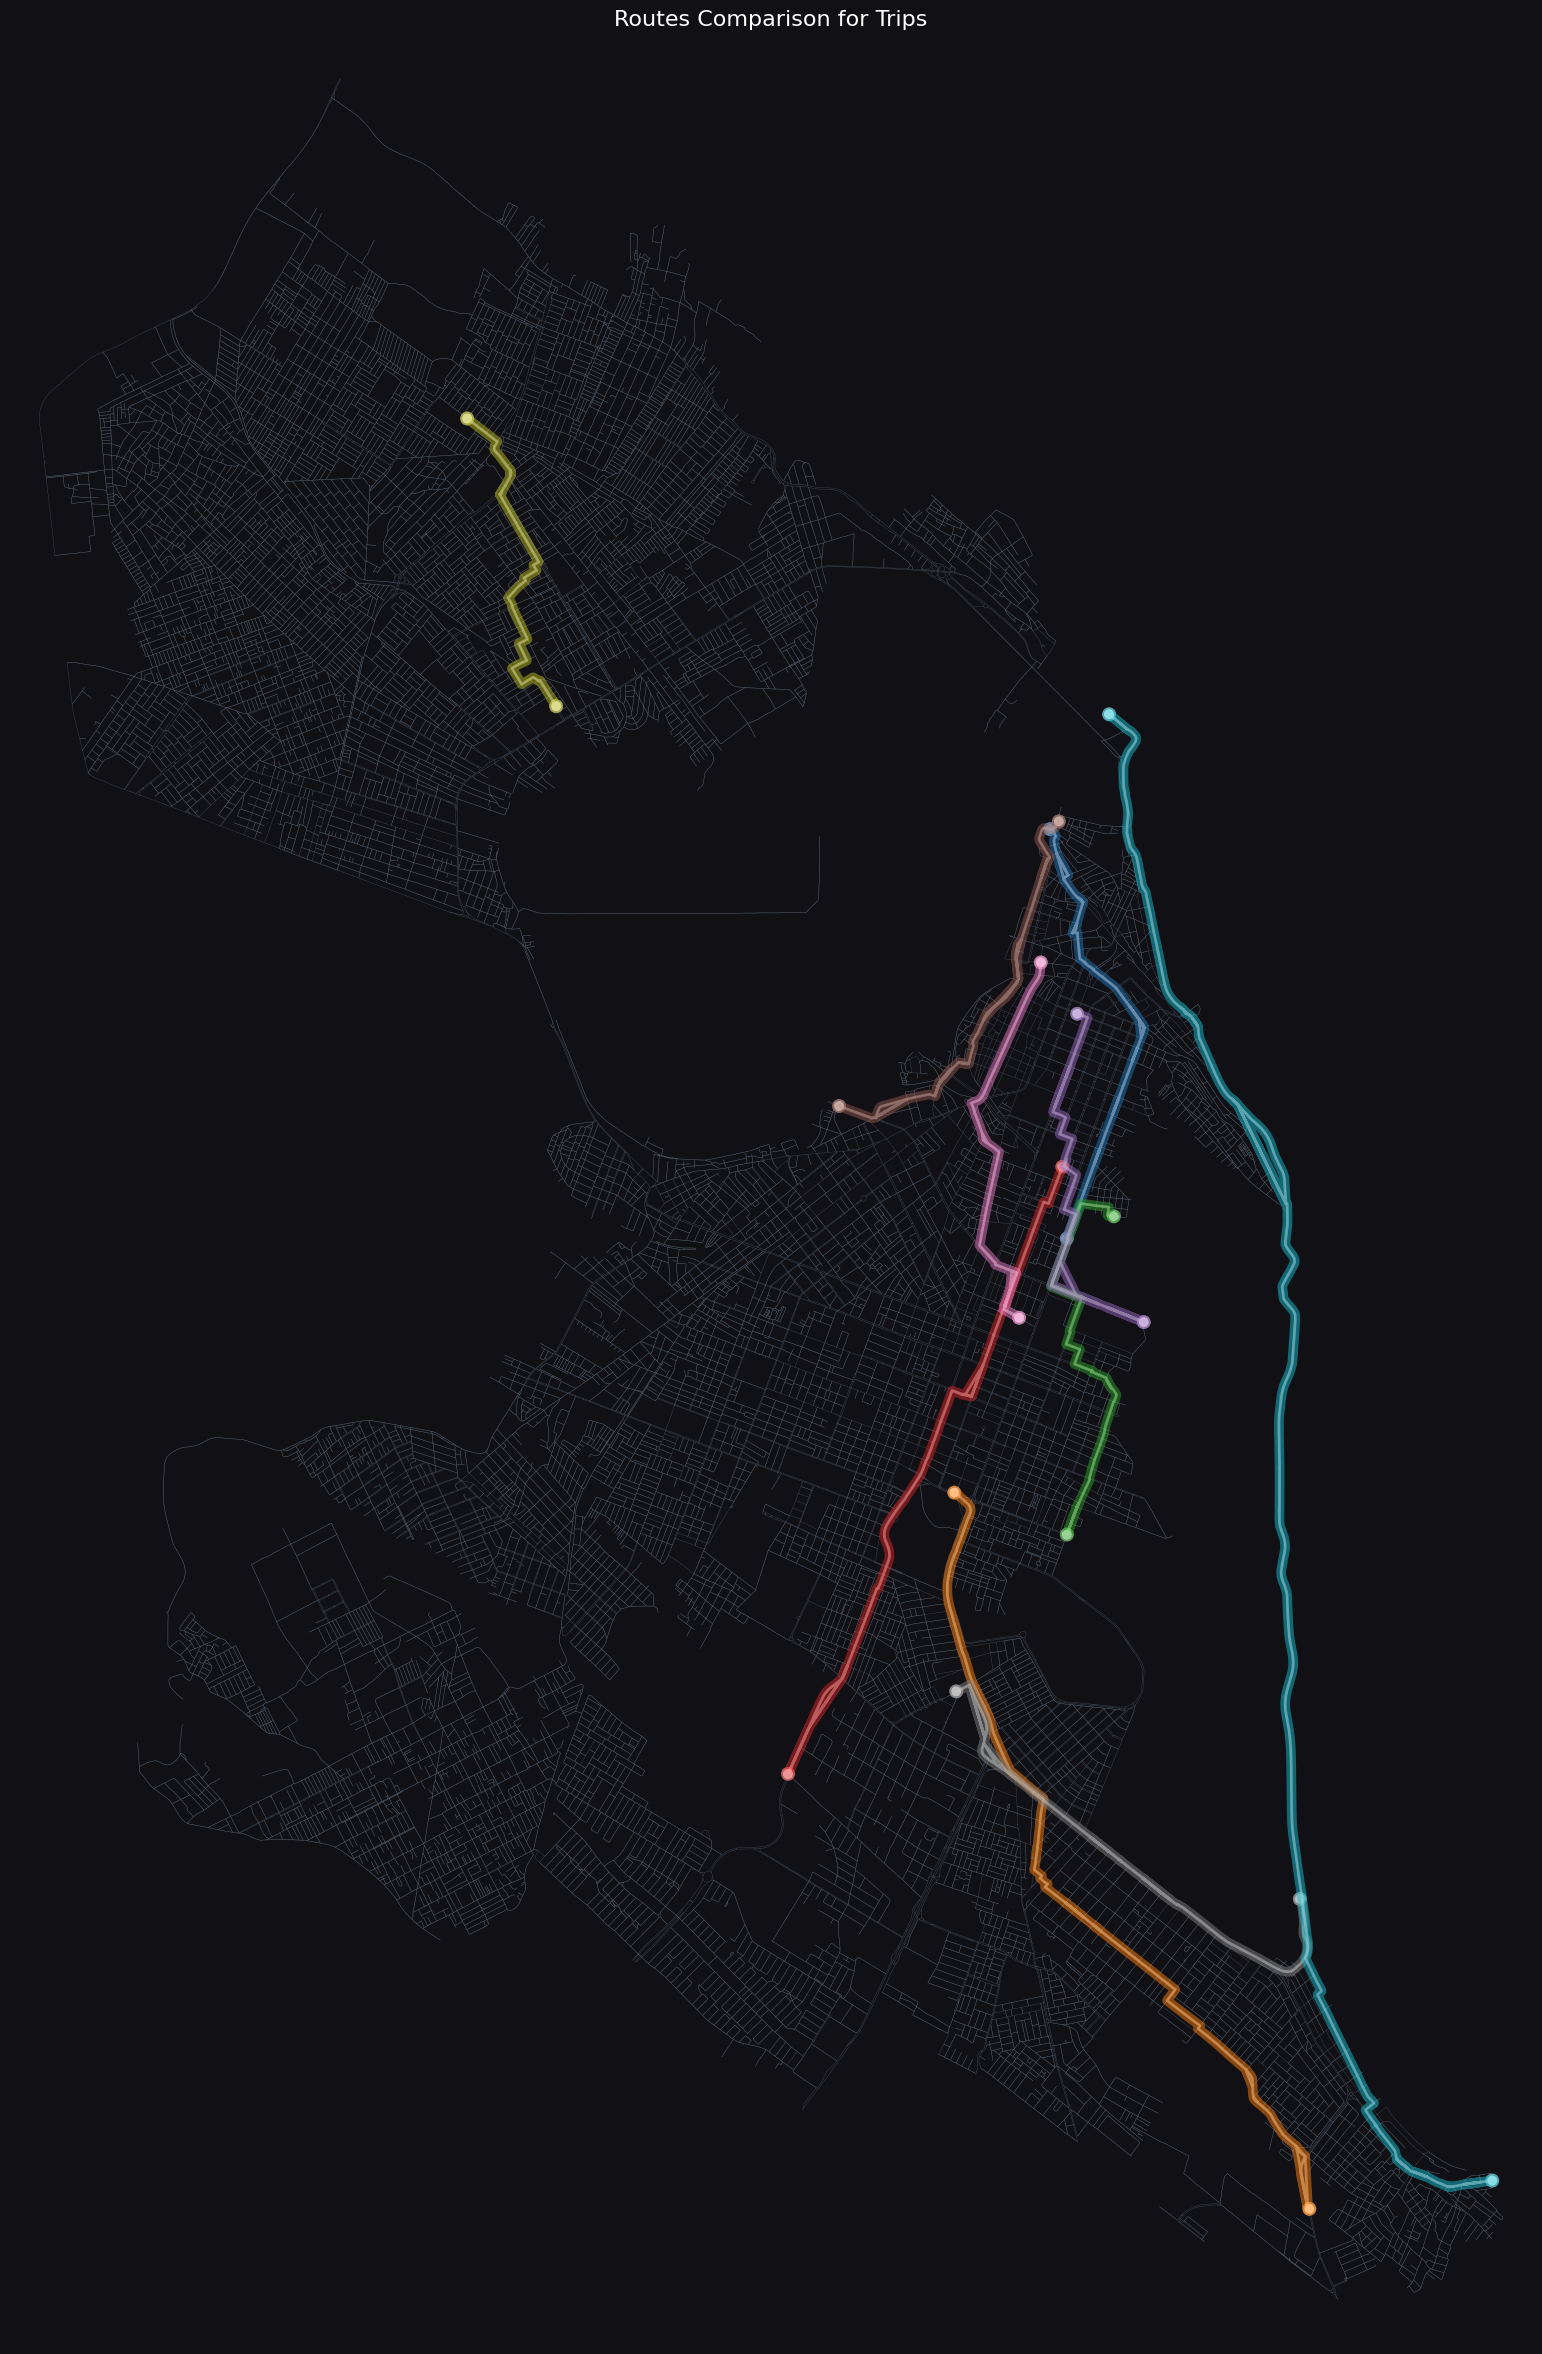

In [23]:
# Plot the routes

# Define node colors and sizes
ns = [50 if node in points_of_interest.values() else 0 for node in G_undirected.nodes()]
nc = ['w' if node in points_of_interest.values() else "none" for node in G_undirected.nodes()]
colors = mpl.colormaps['tab20'].colors

fig, ax = plt.subplots(figsize=(20,30),facecolor='#101015')
ax.set_facecolor('#101015')
ox.plot_graph(
    G_undirected,
    ax = ax,
    show=False,
    close=False,
    node_color=nc,
    node_size=ns,
    edge_color='slategrey',
    edge_linewidth=0.3,
    edge_alpha=0.5,
    bgcolor='#101015',
    node_zorder=2,
    dpi=500
)

ox.plot_graph_routes(G_undirected, routes, route_colors=colors, route_linewidths=[7,2]*len(trips), ax=ax, show=False, close=False)

plt.title("Routes Comparison for Trips", fontsize=16, color='w')
plt.show()

## Minimum Spanning Tree

To create a MST for the 20 POIs, we first need to "isolate" them, i.e., we should create a representation of our current graph focusing only on the relationship between the points, in this case, the distance between them.

First we gotta make a complete graph where each edge has the weight of the shortest path between each pair of nodes in the original graph and then get the Minimum Spanning Tree for this graph.


In [24]:
mst_routes = {}
G_interest = nx.Graph()
for i in range(len(pois_nodes)):
    for j in range(i+1, len(pois_nodes)):
        route = nx.shortest_path(G_undirected, pois_nodes[i], pois_nodes[j], weight='length')
        mst_routes[(pois_nodes[i], pois_nodes[j])] = route
        route_length = nx.shortest_path_length(G_undirected, pois_nodes[i], pois_nodes[j], weight='length')
        # route_length = 0
        # for k in range(len(route)-1):
        #     route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Get the length of the first edge in the list
        G_interest.add_edge(pois_nodes[i], pois_nodes[j], weight=route_length)

mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))

# Used for comparison later
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])

To view the MST properly, we should reverse the mapping we did in order to represent the actual paths/edges. This is done with the first `for` loop.

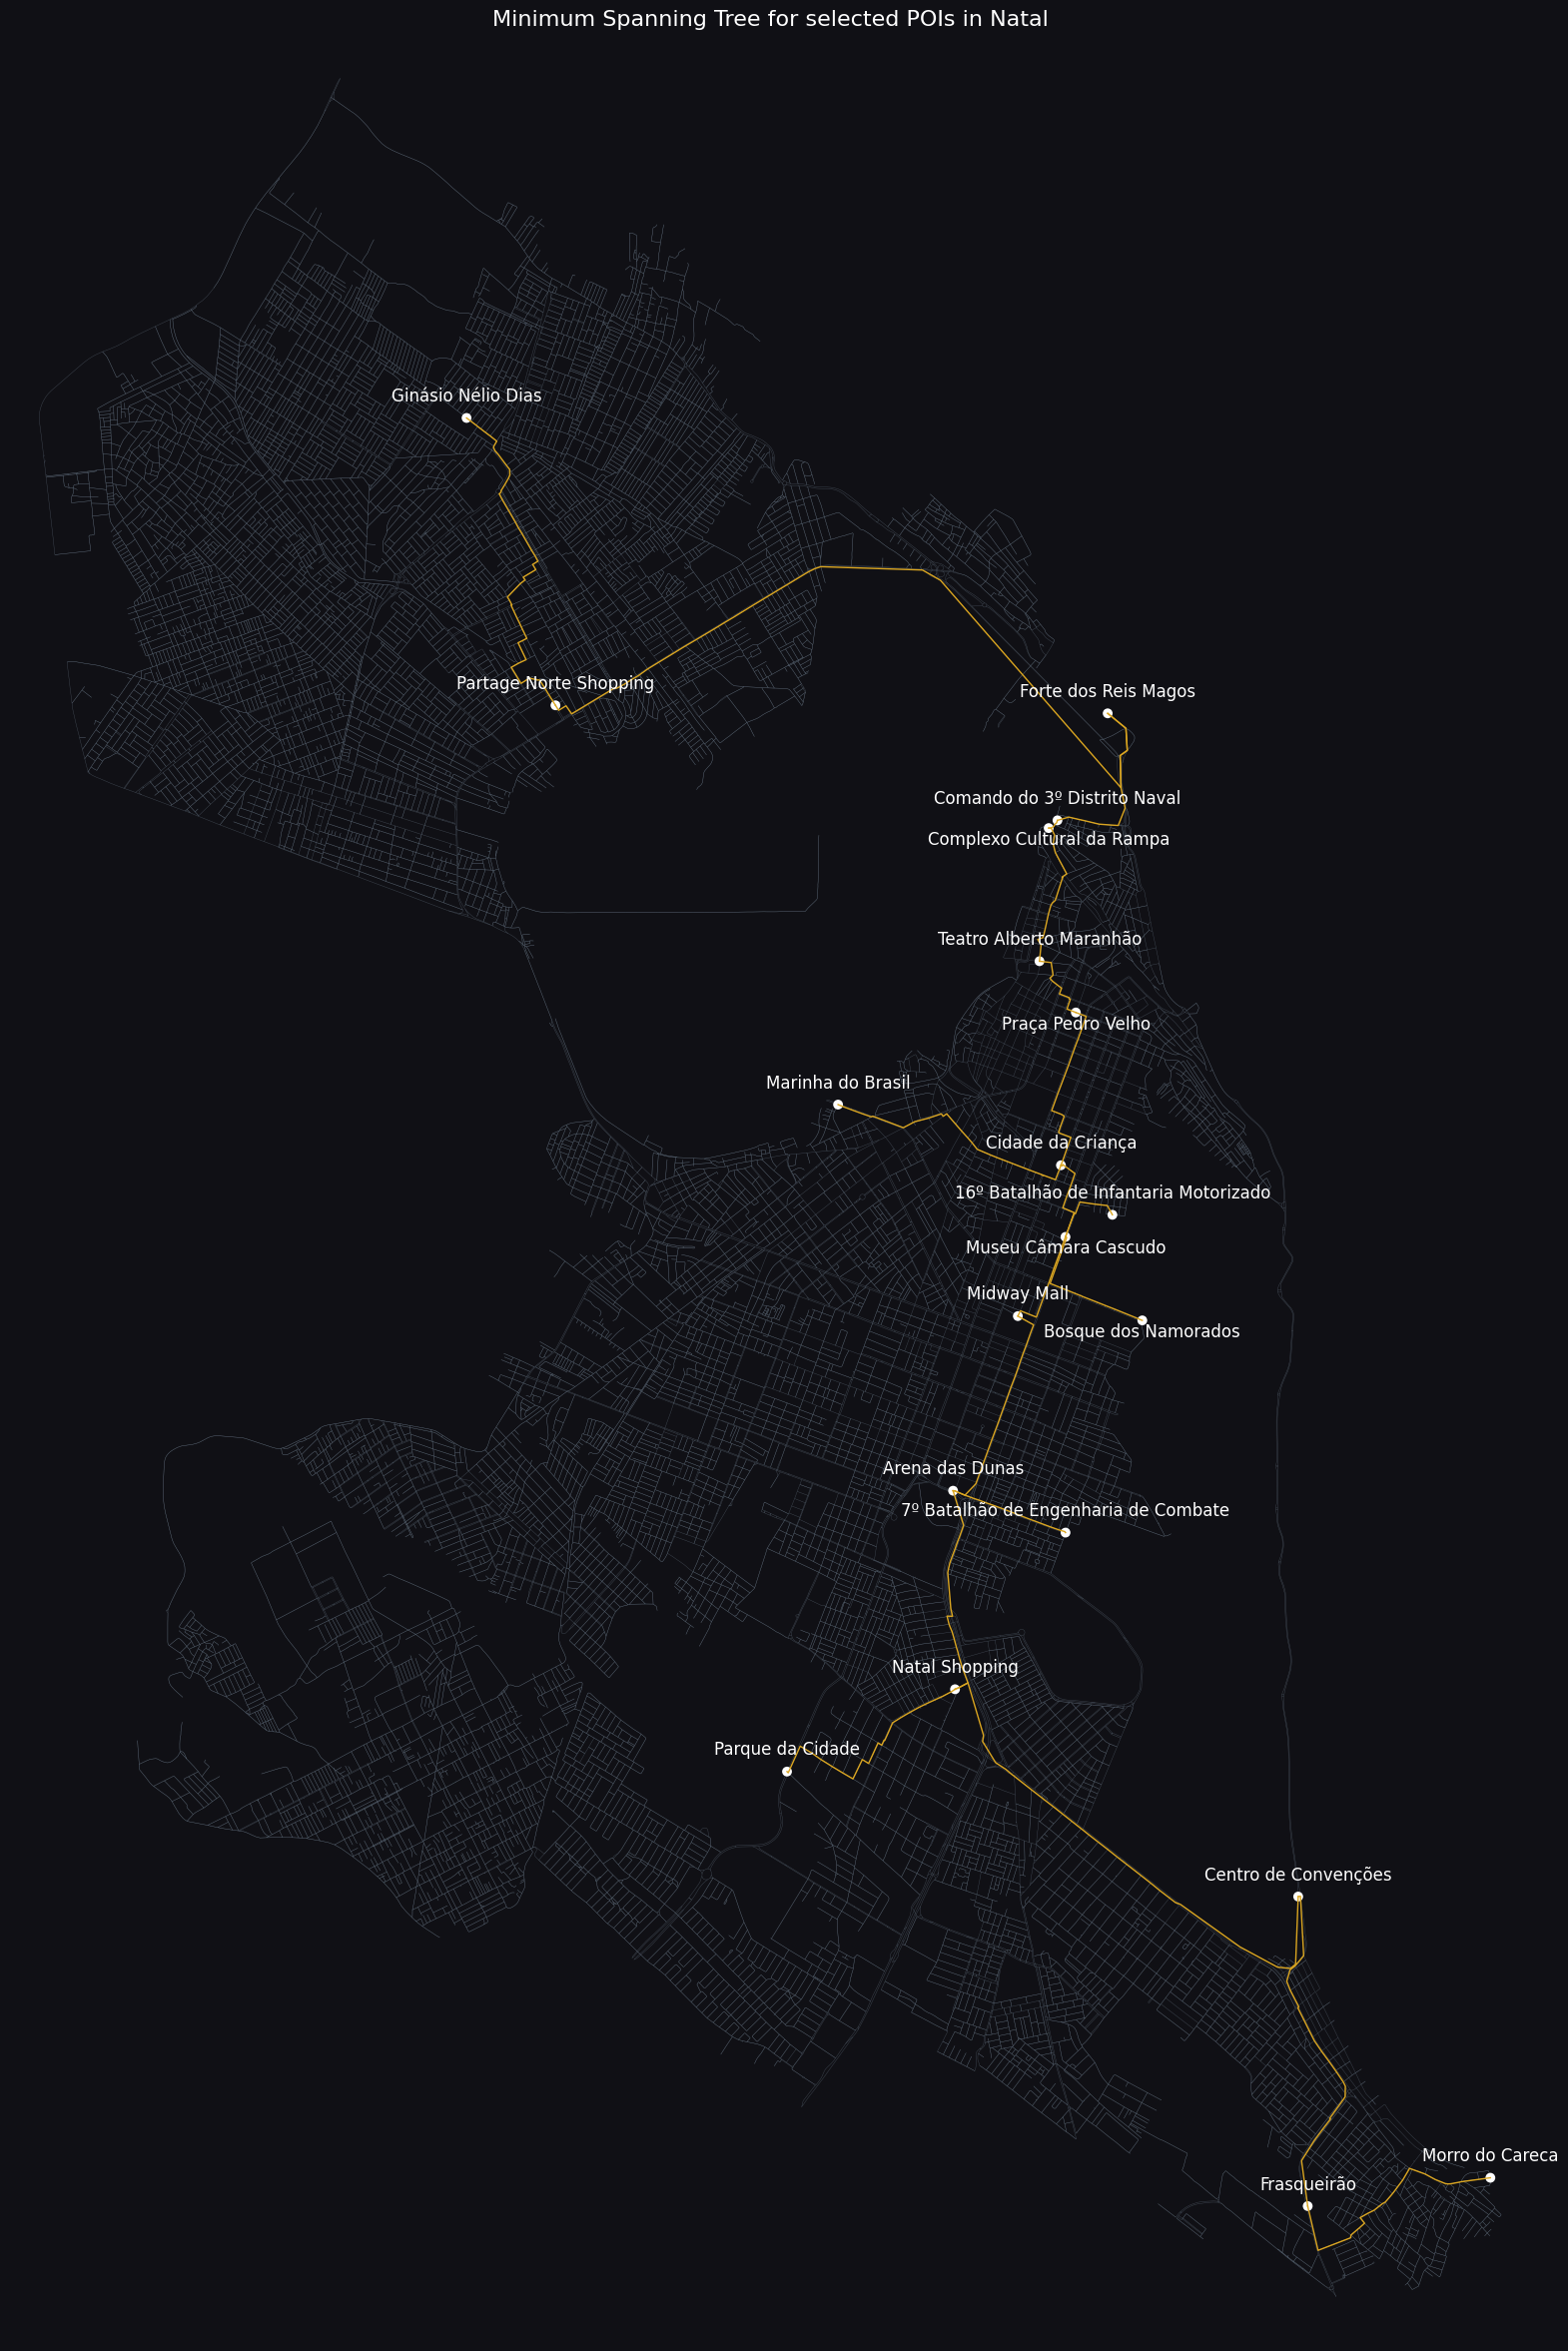

In [25]:
fig, ax = plt.subplots(figsize=(20,30),facecolor='#101015')
ax.set_facecolor('#101015')
ox.plot_graph(
    G_undirected,
    ax = ax,
    show=False,
    close=False,
    node_color=nc,
    node_size=ns,
    edge_color='slategrey',
    edge_linewidth=0.3,
    edge_alpha=0.5,
    bgcolor='#101015',
    dpi=500
)
for u, v, _ in mst_edges:
    route = mst_routes[u,v]
    # ox.plot_graph_route(G_undirected, route, route_color='goldenrod', route_linewidth=2, ax=ax, show=False, close=False)
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='goldenrod', linewidth=1, zorder=2)

# Create a reverse dictionary for points_of_interest
reverse_points_of_interest = {v: k for k, v in points_of_interest.items()}

# Annotate the names of the POIs on the map to make it easier to identify them
for id, node in ox.convert.graph_to_gdfs(G_undirected, edges=False).fillna("").iterrows():
    text = reverse_points_of_interest.get(id, "")
    c = node["geometry"]
    xytext = (0, 1)
    if text in close_nodes:
        xytext= (0, -1)
    ax.annotate(text, (c.x, c.y), color="w", fontsize=12, zorder=3, textcoords="offset fontsize", xytext=xytext, ha='center')

plt.title("Minimum Spanning Tree for selected POIs in Natal", fontsize=16, color='white')
plt.show()

## Analysis and Conclusion

After all this, we can draw some conclusions and pay attention to some relevant aspects, but first let's take a look at some numbers.

In [26]:
# Check if the routes are the same
is_same = all(x == y for x, y in zip(routes[::2], routes[1::2]))
if is_same:
    print('The routes are the same.')
else:
    print('The routes are different.')
print(f'The total distance of the trips is {trip_total_distance/1000:.2f} kilometers.')
print(f"The total length of the MST that spans all 20 POIs is {total_mst_length/1000:.2f} kilometers.")

The routes are the same.
The total distance of the trips is 61.81 kilometers.
The total length of the MST that spans all 20 POIs is 43.60 kilometers.


As we can see, both the implementations of Dijsktra's algorithm yielded the same route, as they should've. The real change couldn't be measured visually as it resides in the time complexity of the algorithm. This is difficult to properly measure in this assignment because there are some issues regarding aspects like isolated algorithm behavior, the data each algorithm manipulates, even the index mapping has some interference in the overall performance.

Another important point to consider is that some information is lost in translation when we convert a `MultiDiGraph` to `MultiGraph`. We can see effects of that in particular when calculating the length of the route for each pair of nodes right before generating the MST, we disregard the potentially shorter edges when we take the length of the first one. However, even if we'd considered the smallest of them all, it could be a representation of an edge in the wrong direction (a car driving the wrong way in the real world).

One observation to be made about the trips and the MST is that despite having a short total length, it isn't a fair comparison between the two because the MST doesn't serve the purpose of minimizing travel distance (not in all cases, e.g., frequents culs-de-sac) and it doesn't accommodate for the thematic experience we can achieve with trips, but it still has its uses.